In [1]:
import os.path

import matplotlib.pyplot as plt
# Imports for ML model

import numpy as np
import tensorflow as tf
import keras
from keras.layers import Normalization



In [2]:
# Filter out corrupted images
num_skipped = 0
data_label = []
for folder_name in ("Apple_Black_rot", "Apple_Cedar_apple_rust", "Apple_healthy", "Apple_Powdery_mildew", "Apple_scab"):
    folder_path = os.path.join("testPlants", folder_name)
    for f_name in os.listdir(folder_path):
        f_path = os.path.join(folder_path, f_name)
        try:
            f_obj = open(f_path, "rb")
            is_jpg = tf.compat.as_bytes("JFIF") in f_obj.peek(10)
        finally:
            f_obj.close()
        if not is_jpg:
            num_skipped += 1
            # Delete corrupted images
            os.remove(f_path)

In [3]:
# Generate a Dataset
image_size = (256, 256)
batch_site = 32
train_labels = [(1, 'Apple_Black_rot'), (2, 'Apple_Cedar_apple_rust'), (3, 'Apple_healthy'), (4, 'Apple_Powdery_mildew'),(5, 'Apple_scab')]

train_data, test_data = tf.keras.utils.image_dataset_from_directory(
    "testPlants",
    validation_split= 0.2,
    subset= "both",
    seed= 1337,
    image_size=image_size,
    batch_size=batch_site,
    labels= "inferred"

)


Found 180 files belonging to 5 classes.
Using 144 files for training.
Using 36 files for validation.


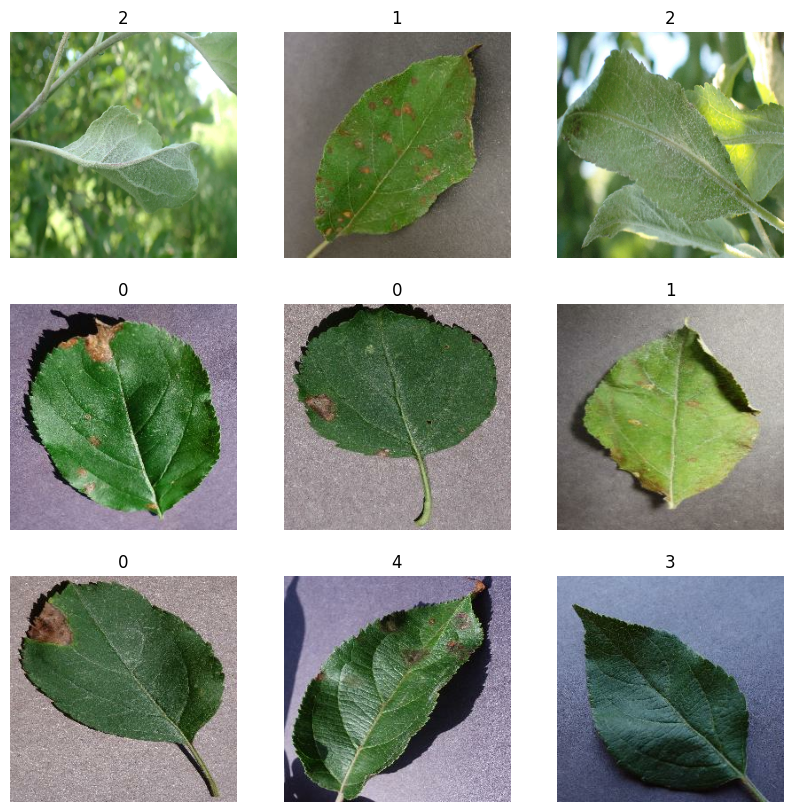

In [10]:
# Visualization of data
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for images, labels in train_data.take(1):
    for i in range (9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

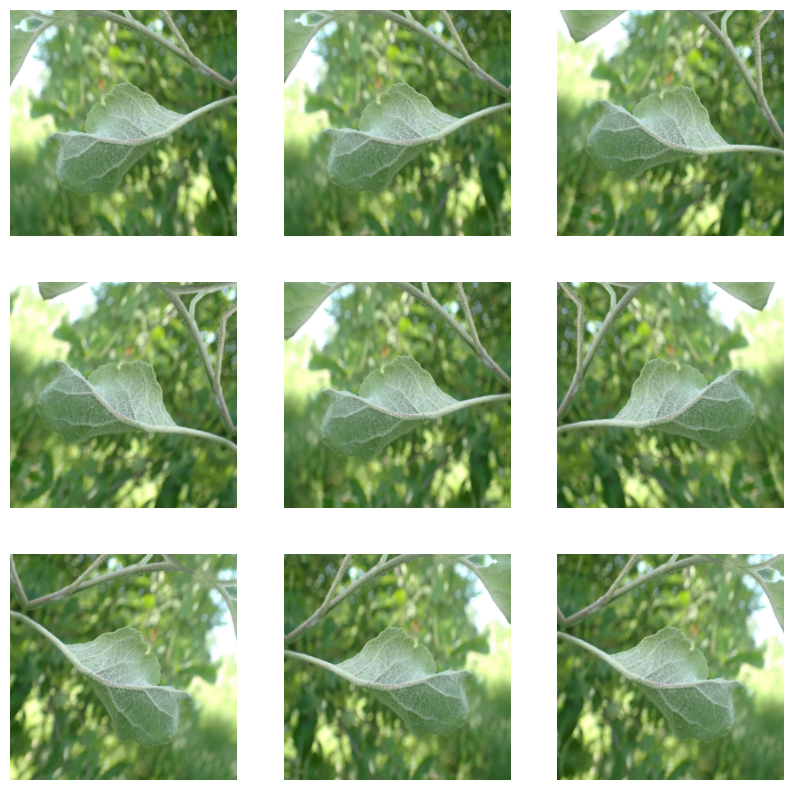

In [4]:
# Using image data augmentation
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [5]:
# Preprocessing data for ML model
# augmentation will happen on CPU
# Apply `data_augmentation` to the training images.
augmented_train_ds = train_data.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls = tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)


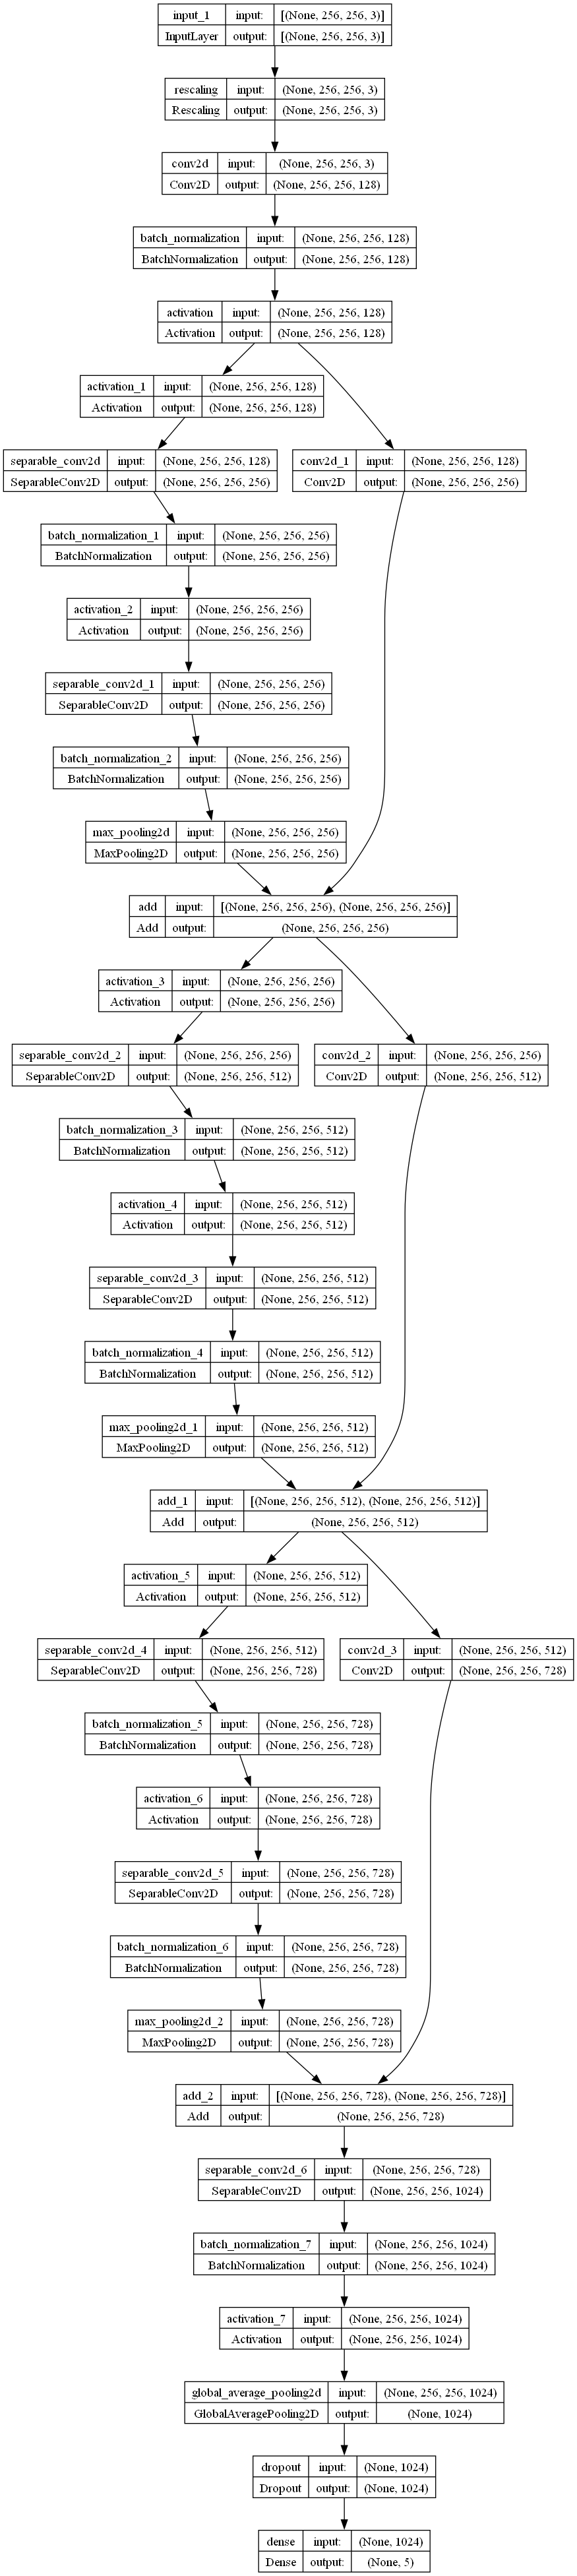

In [6]:
# Build a model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    #Entry block
    x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
    x = tf.keras.layers.Conv2D(128,3,strides=1, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    
    previous_block_activation = x #set aside residual
    
    for size in [256, 512, 728]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = tf.keras.layers.MaxPooling2D(3, strides=1, padding="same")(x)
        
        #Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=1, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual]) # Add back residual
        previous_block_activation = x # Set aside next residual
        
    x = tf.keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    #if num_classes == 2:
    #    activation = "sigmoid"
    #    units = 1
    #else:
    activation = "softmax"
    units = 5    
        
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(image_size + (3,), 5)
keras.utils.plot_model(model, show_shapes=True)


In [36]:
'''
model = keras.Sequential([
    tf.keras.layers.Conv2D(64,activation='relu', kernel_size=(3,3)),
    tf.keras.layers.Conv2D(128,activation='relu', kernel_size=(3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation='softmax')
])'''

In [7]:
# Train the model
from keras.callbacks import ModelCheckpoint
#epochs = 25

callbacks = [
    ModelCheckpoint("model_weights_epoch_{epoch}.h5", save_best_only=True),
]

# Instantiate the BinaryFocalCrossentropy loss function
loss_fn = keras.losses.BinaryCrossentropy()

model.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss='sparse_categorical_crossentropy',  # Use the instantiated loss function
    metrics=["accuracy"],
)

model.fit(
    train_data,
    epochs=5,
    callbacks=callbacks,
    validation_data=test_data,
)

Epoch 1/5


ResourceExhaustedError: Graph execution error:

Detected at node model/activation_5/Relu defined at (most recent call last):
  File "C:\Users\zbq46b\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main

  File "C:\Users\zbq46b\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\zbq46b\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 601, in run_forever

  File "C:\Users\zbq46b\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1905, in _run_once

  File "C:\Users\zbq46b\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\zbq46b\AppData\Local\Temp\ipykernel_1584\2475266064.py", line 18, in <module>

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\engine\training.py", line 1742, in fit

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\engine\training.py", line 1080, in train_step

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\engine\training.py", line 569, in __call__

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\engine\functional.py", line 512, in call

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\layers\core\activation.py", line 59, in call

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\activations.py", line 321, in relu

  File "C:\Users\zbq46b\PycharmProjects\Plants\venv\lib\site-packages\keras\src\backend.py", line 5397, in relu

OOM when allocating tensor with shape[32,256,256,512] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node model/activation_5/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_8178]